Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r".\Train")
data_dir_test = pathlib.Path(r".\Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

### Create a dataset

In [6]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (None, 180, 180, 3)

In [7]:
## Importing the train dataset here. Validation set not required since there is a separate validate set already
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train,
                                                                seed = 123,
                                                                image_size = (img_height, img_width),
                                                                batch_size = batch_size )

Found 2239 files belonging to 9 classes.


In [8]:
## Importing the validate dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_test,
                                                              seed = 123,
                                                              image_size = (img_height, img_width),
                                                              batch_size = batch_size )


Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)
print (num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

tf.Tensor([8 4 5 5 3 2 5 0 1 5 7 4 0 4 7 3 3 5 1 5 3 1 1 1 0 1 5 4 2 7 4 1], shape=(32,), dtype=int32)
tf.Tensor([4 6 3 4 4 5 4 0 6 6 3 1 4 8 5 1 5 5 1 5 4 5 6 0 5 4 4 5 5 4 4 5], shape=(32,), dtype=int32)


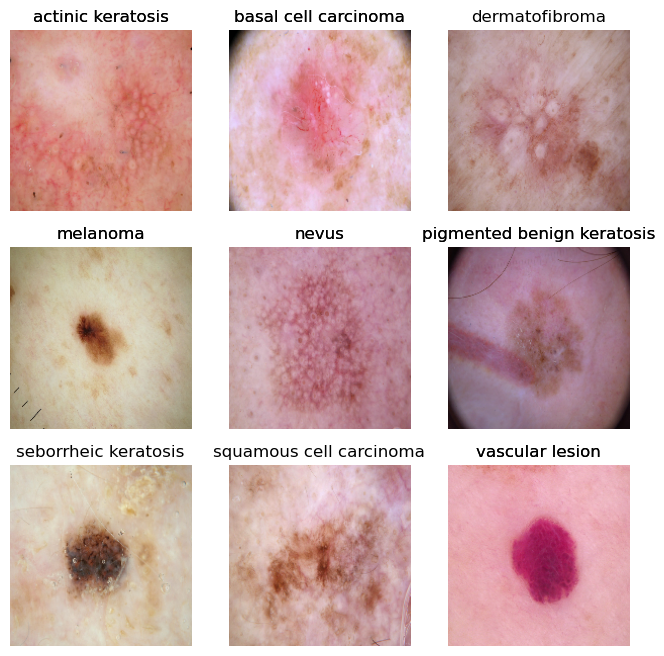

In [10]:
fig = plt.figure(figsize=(8,8))
num_classes = len(class_names)

for images, labels in train_ds.take(2):
    print (labels)
    for i in range (num_classes):
        for j in range (batch_size):
            if (labels[j] == i):
                fig.add_subplot(3, 3, i + 1)
                plt.title(class_names[labels[j]])
                plt.imshow(images[j].numpy().astype("uint32"))
                plt.axis("off")
                break
                
plt.show() 
    

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
# Unchanged code
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
## Convert the class labels into binary format
one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=9)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=9)))

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset.

In [13]:
model = Sequential()

model.add(Rescaling(1./255, offset=0.0)) # normalize pixel values between (0,1)
model.add(Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (img_height,img_width,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(1920, activation = 'relu'))
model.add(Dense(9, activation = 'softmax'))

In [14]:
# View the summary of all layers
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Compile the model

In [15]:
## Select the Adam optimizer and categorical cross entropy as loss model since this is classification 
optm = Adam(learning_rate=0.001)
model.compile(optimizer=optm,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [16]:
epochs = 20
history = model.fit(
  one_hot_encoded_train_ds,
  validation_data=one_hot_encoded_val_ds,
  epochs=epochs
)

Epoch 1/20


70/70 [==============================] - 76s 886ms/step - loss: 2.3944 - accuracy: 0.2568 - val_loss: 2.1302 - val_accuracy: 0.2034
Epoch 2/20
70/70 [==============================] - 52s 736ms/step - loss: 1.6070 - accuracy: 0.4332 - val_loss: 1.9091 - val_accuracy: 0.3136
Epoch 3/20
70/70 [==============================] - 38s 544ms/step - loss: 1.4513 - accuracy: 0.4868 - val_loss: 2.2485 - val_accuracy: 0.3051
Epoch 4/20
70/70 [==============================] - 38s 548ms/step - loss: 1.3352 - accuracy: 0.5355 - val_loss: 2.0739 - val_accuracy: 0.3305
Epoch 5/20
70/70 [==============================] - 40s 570ms/step - loss: 1.2334 - accuracy: 0.5636 - val_loss: 2.5333 - val_accuracy: 0.3305
Epoch 6/20
70/70 [==============================] - 40s 574ms/step - loss: 1.1894 - accuracy: 0.5708 - val_loss: 2.0035 - val_accuracy: 0.3983
Epoch 7/20
70/70 [==============================] - 40s 572ms/step - loss: 1.1233 - accuracy: 0.6029 - val_loss: 2.4685 - val_accuracy: 0.34

### Visualizing training results

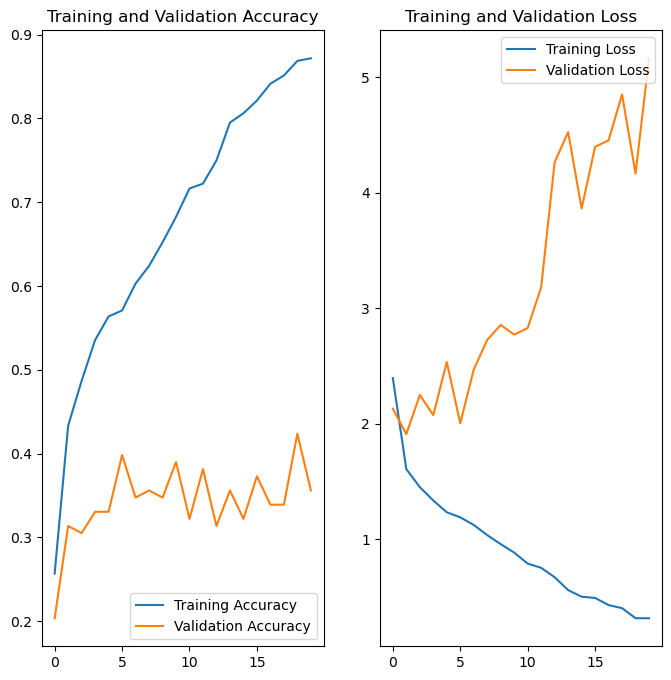

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
Training Accuracy is gradually improving but validation accuracy is not improving much after 8 epochs. It could be a case of 
Overfitting

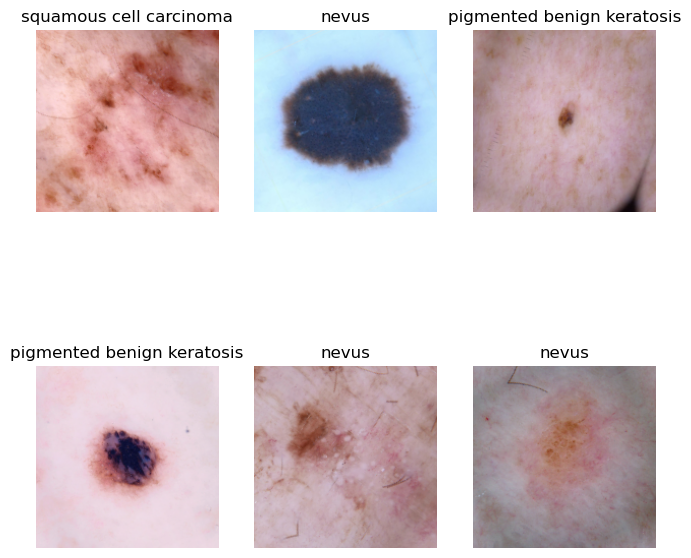

In [18]:
#Visualize how your augmentation strategy works for one instance of training image.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

fig = plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for count in range(6):
        result = data_augmentation(images[count])
        fig.add_subplot(2, 3, count + 1)
        plt.title(class_names[labels[count]])
        plt.imshow(result.numpy().astype("uint32"))
        plt.axis("off")
    
plt.show()

### Create the model, compile and train the model

In [19]:
## Using Dropout layer since there is an evidence of overfitting in your findings

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

model = Sequential()

model.add(data_augmentation)
model.add(Rescaling(1./255, offset=0.0))
model.add(Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (img_height,img_width,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2816, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation = 'softmax'))

In [20]:
model.build(input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Compiling the model

In [21]:
## Select the Adam optimizer and categorical cross entropy as loss model since this is classification 
optm = Adam(learning_rate=0.001)
model.compile(optimizer=optm,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [22]:
epochs = 20
history = model.fit(
  one_hot_encoded_train_ds,
  validation_data=one_hot_encoded_val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 131s 2s/step - loss: 4.2621 - accuracy: 0.1907 - val_loss: 2.1558 - val_accuracy: 0.1186
Epoch 2/20
70/70 [==============================] - 111s 2s/step - loss: 1.8912 - accuracy: 0.3042 - val_loss: 2.1300 - val_accuracy: 0.2966
Epoch 3/20
70/70 [==============================] - 109s 2s/step - loss: 1.6038 - accuracy: 0.4323 - val_loss: 1.9981 - val_accuracy: 0.2542
Epoch 4/20
70/70 [==============================] - 111s 2s/step - loss: 1.5289 - accuracy: 0.4453 - val_loss: 2.0419 - val_accuracy: 0.2373
Epoch 5/20
70/70 [==============================] - 110s 2s/step - loss: 1.5169 - accuracy: 0.4694 - val_loss: 2.1185 - val_accuracy: 0.2966
Epoch 6/20
70/70 [==============================] - 111s 2s/step - loss: 1.4844 - accuracy: 0.4824 - val_loss: 2.4818 - val_accuracy: 0.2627
Epoch 7/20
70/70 [==============================] - 112s 2s/step - loss: 1.4636 - accuracy: 0.4891 - val_loss: 2.0958 - val_accuracy: 0.2881
Epoch 8/20
70

### Visualizing the results

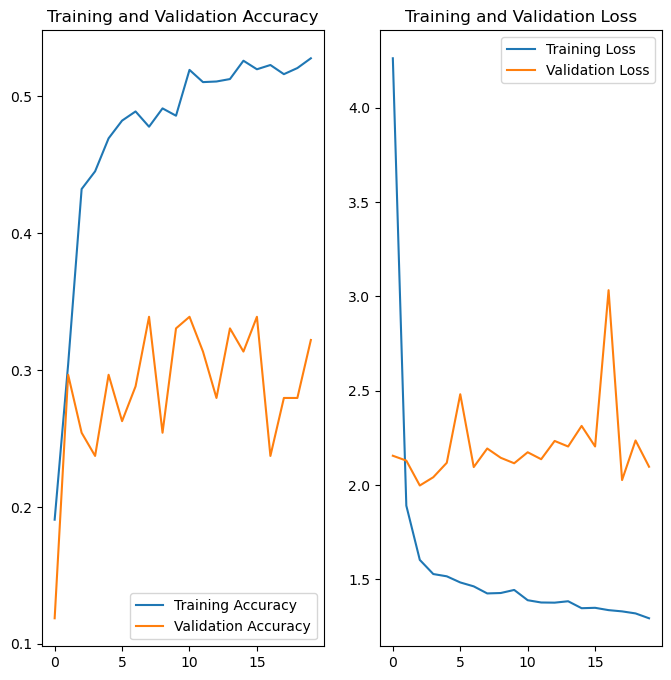

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
There is a marginal improvement as compared to the previous model run in terms of overfitting. However the validation accuracy is still not great. The data augmentation has not helped. The model without data augmentation but with dropout had a validation accuracy of 40%

#### Find the distribution of classes in the training dataset to address the problem of class imbalance.

<Axes: xlabel='class'>

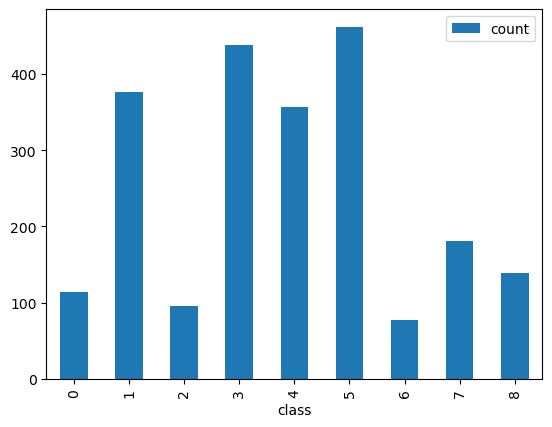

In [24]:
df = pd.DataFrame({"class":[0, 1, 2, 3, 4, 5, 6, 7, 8],
                   "count":[0, 0, 0, 0, 0, 0, 0, 0, 0]})

for images, labels in train_ds:
    arr = labels.numpy()
    for j in range (arr.size):
        df.loc[arr[j], 'count'] += 1

df.plot.bar(x='class', y='count')

#### - Which class has the least number of samples?
Class 6 or 'seborrheic keratosis' has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
Class 1, 3, 4, 5 seem to dominate the number of samples
1 - basal cell carcinoma, 3 - melanoma, 4 - nevus, 5 - pigmented benign keratosis

## Rectify the class imbalance

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
# Unchanged code
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x142C7DEAAD0>: 100%|█| 500/500 [00:05<00:


Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x140D8131750>: 100%|█| 500/500 [00:05<00:00, 95.36 Samples/


Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x142C7CCB090>: 100%|█| 500/500 [00:05<00:


Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x142C7CDDA50>: 100%|█| 500/500 [00:32<00:00, 15.47 Samples


Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x142C7DD3E10>: 100%|█| 500/500 [00:22<00:00, 22.35 Samples


Initialised with 462 image(s) found.
Output directory set to Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x141BE0D0750>: 100%|█| 500/500 [00:04<00:00, 100.06 Samples


Initialised with 77 image(s) found.
Output directory set to Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x140F3AA8390>: 100%|█| 500/500 [00:12<00:00, 40.47 Samples


Initialised with 181 image(s) found.
Output directory set to Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x142C7C341D0>: 100%|█| 500/500 [00:05<00:00, 94.93 Samples/


Initialised with 139 image(s) found.
Output directory set to Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x142C7E8CF10>: 100%|█| 500/500 [00:05<00:00, 92.18 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
1,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
2,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
3,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
4,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
...,...,...
4495,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4496,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4497,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4498,Train\vascular lesion\output\vascular lesion_o...,vascular lesion


In [31]:
df2['Label'].value_counts()


actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [33]:
datagen=ImageDataGenerator()

train_generator=datagen.flow_from_dataframe(
    dataframe=df2,
    x_col="Path",
    y_col="Label",
    subset="training",
    batch_size=batch_size,
    seed=123,
    class_mode="categorical",
    target_size=(img_height,img_width))


Found 4500 validated image filenames belonging to 9 classes.


#### Create the model

In [34]:
model = Sequential()

model.add(Rescaling(1./255, offset=0.0))
model.add(Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (img_height,img_width,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2816, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation = 'softmax'))

In [35]:
model.build(input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

#### Compile the model

In [36]:
## Select the Adam optimizer and categorical cross entropy as loss model since this is classification 
optm = Adam(learning_rate=0.001)
model.compile(optimizer=optm,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [37]:
epochs = 30
history = model.fit(
  train_generator,
  validation_data=one_hot_encoded_val_ds,
  epochs=epochs
)

Epoch 1/30
141/141 [==============================] - 250s 2s/step - loss: 2.7063 - accuracy: 0.1158 - val_loss: 2.1911 - val_accuracy: 0.1356
Epoch 2/30
141/141 [==============================] - 217s 2s/step - loss: 2.1979 - accuracy: 0.1064 - val_loss: 2.1967 - val_accuracy: 0.1356
Epoch 3/30
141/141 [==============================] - 216s 2s/step - loss: 2.1979 - accuracy: 0.1033 - val_loss: 2.1994 - val_accuracy: 0.1356
Epoch 4/30
141/141 [==============================] - 220s 2s/step - loss: 2.1981 - accuracy: 0.1087 - val_loss: 2.1970 - val_accuracy: 0.1102
Epoch 5/30
141/141 [==============================] - 224s 2s/step - loss: 2.1972 - accuracy: 0.1093 - val_loss: 2.1984 - val_accuracy: 0.0339
Epoch 6/30
141/141 [==============================] - 219s 2s/step - loss: 2.1654 - accuracy: 0.1413 - val_loss: 2.1987 - val_accuracy: 0.0254
Epoch 7/30
141/141 [==============================] - 215s 2s/step - loss: 2.1992 - accuracy: 0.1044 - val_loss: 2.1929 - val_accuracy: 0.1356

#### Visualize the model results

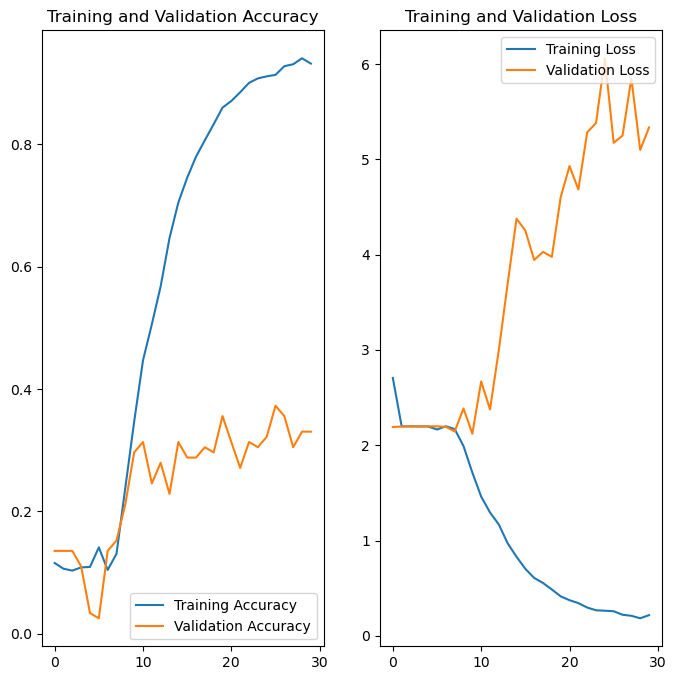

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze the results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Even after addressing the class imbalance problem, the performance has not improved. That is the case for other models too
The training model accuracy has reached over 90% but validation accuracy continues to remain low. Validation loss is high.
There may be a few reasons.
    1. It looks like the test data set is different from the train data
    2. The images between various data sets look somewhat alike and difficult for the algorithm to differentiate
    3. Model may need to be further refined as a potential next step
